In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
import scipy.stats as stats
from tqdm.auto import tqdm
import seaborn as sns
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
import random
import platform
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,  DataLoader

warnings.filterwarnings('ignore')
plt.style.use('dark_background')                # 그래프 배경 색상 변경
if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')              # 한글폰트 깨짐현상 제거
else:
    rc('font', family = 'NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'retina'  # 그래프 고해상도로 출력

In [2]:
PATH = os.getcwd() + '/data/'
df_brand = pd.read_csv(PATH + 'brand_keyword_cnt.csv')
pd_info = pd.read_csv(PATH + 'product_info.csv')
sales = pd.read_csv(PATH + 'sales.csv')
df_smp = pd.read_csv(PATH + 'sample_submission.csv')
train = pd.read_csv(PATH + 'train.csv')
smp = train.sample(10)

# Dataset Info.
### train.csv
* ID: 실제 판매되고 있는 고유 ID
* 제품: 제품 코드
* 대분류: 제품의 대분류 코드
* 중분류: 제품의 중분류 코드
* 소분류: 제품의 소분류 코드
* 브랜드: 제품의 브랜드 코드
* 2022-01-01 ~ 2023-04-04: 실제 일별 판매량
* `단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음`
* `즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널`

### sample_submmision.csv
* 2023-04-05 ~ 2023-04-25: 예측한 일별 판매량

### sales.csv - 메타(Meta) 정보
* ID : 실제 판매되고 있는 고유 ID
* 제품 : 제품 코드
* 대분류 : 제품의 대분류 코드
* 중분류 : 제품의 중분류 코드
* 소분류 : 제품의 소분류 코드
* 브랜드 : 제품의 브랜드 코드
* 2022-01-01 ~ 2023-04-04 : 실제 일별 총 판매금액
* `단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음`
* `즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널`

### brand_keyword_cnt.csv - 메타(Meta) 정보
* 브랜드: 브랜드 코드
* 2022-01-01 ~ 2023-04-04 : 브랜드의 연관키워드 언급량을 **정규화**한 일별 데이터

### product_info.csv [파일] - 메타(Meta) 정보
* 제품 : 제품 코드
* 제품특성 : 제품 특성 데이터(Text)
* `train.csv에 존재하는 모든 제품 코드가 포함되어 있지 않음. 또는 product_info.csv에 존재하는 제품 코드가 train csv에 존재하지 않을 수 있음`


## EDA

In [3]:
def data_melt(df):
    new_df = df.melt(id_vars=df.iloc[:, :6].columns.to_list(), value_vars=df.iloc[:, 6:].columns.to_list())
    new_df = new_df.rename(columns = {'variable' : 'date', 'value' : 'sales'})

    return new_df

In [4]:
def datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    return df

In [5]:
df_train = data_melt(train)
df_train = datetime(df_train)
df_train.head(3)

,ID,제품,대분류,중분류,소분류,브랜드,date,sales,year,month,day,day_of_week,day_name,quarter
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,1,5,Saturday,1
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1


In [6]:
# # Label Encoding
# train_enc = df_train.copy()
# label_encoder = LabelEncoder()
# categorical_columns = ['대분류', '중분류', '소분류', '브랜드', 'day_name']

# for col in tqdm(categorical_columns):
#     label_encoder.fit(train_enc[col])
#     train_enc[col] = label_encoder.transform(train_enc[col])
#     if col == 'day_name':
#         li = [0, 1, 2, 3, 4, 5, 6]
#         for l in li:
#             print(l , '->', label_encoder.inverse_transform([l]))

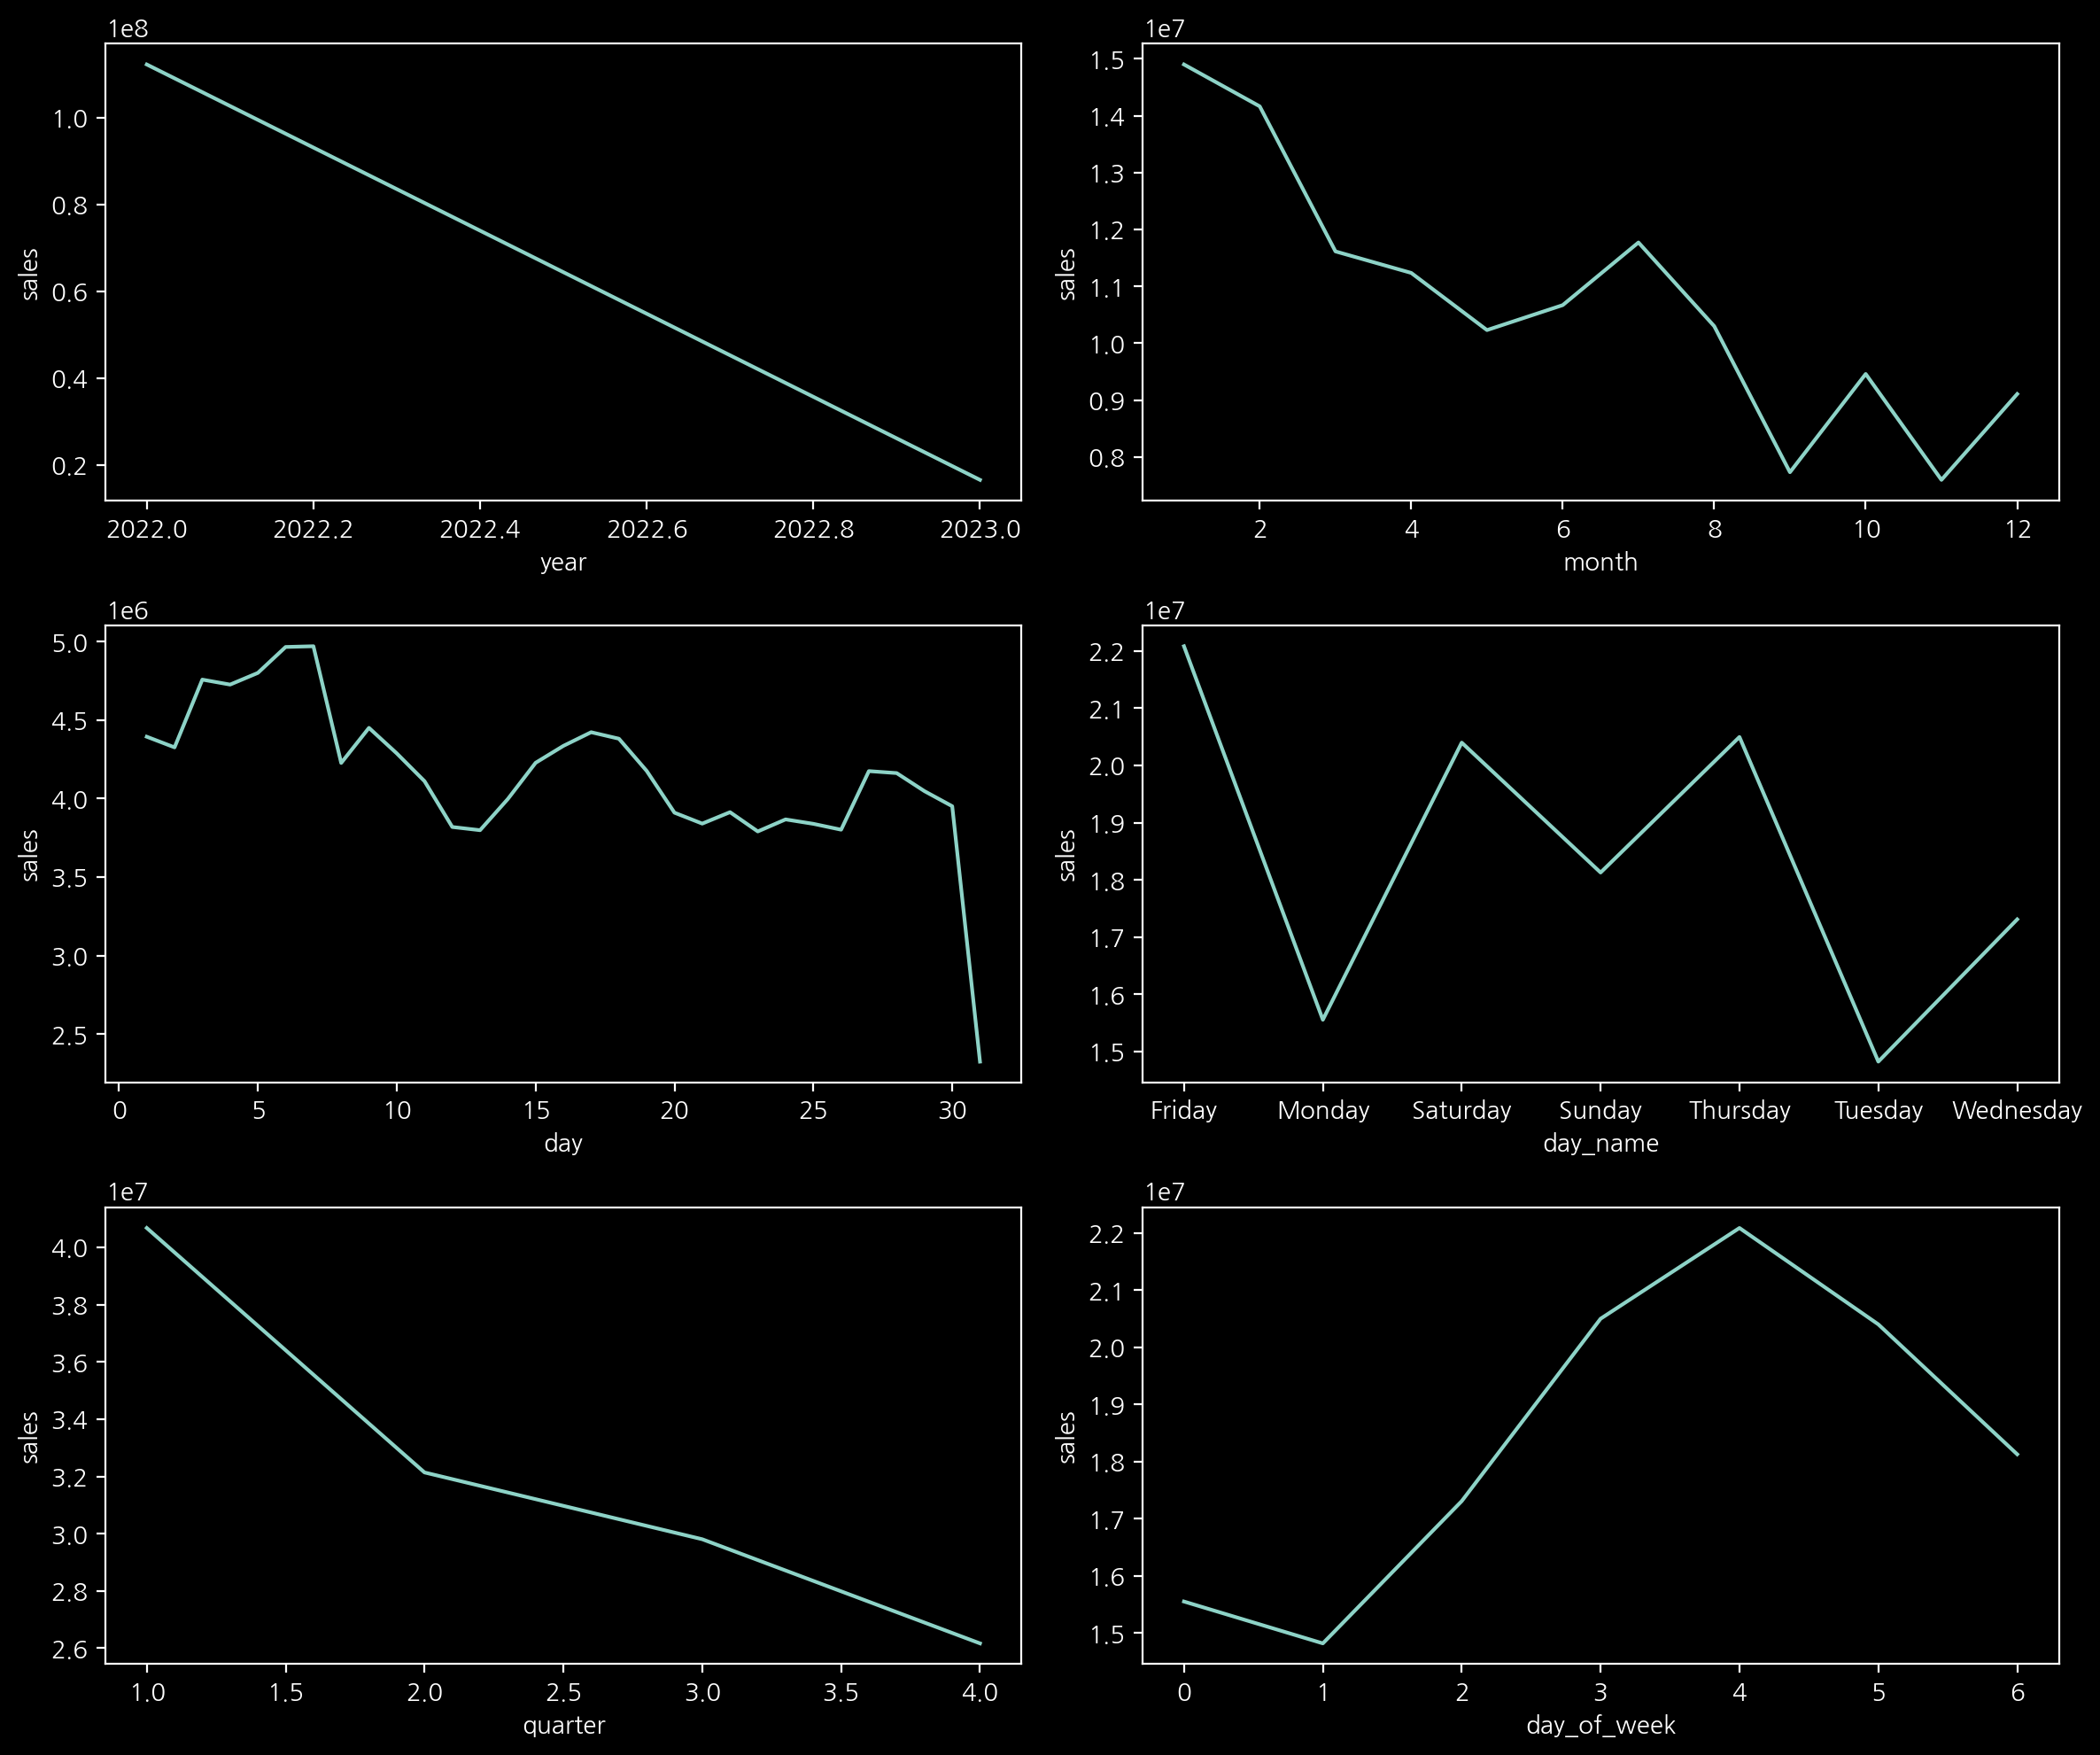

In [7]:
grouping_colunms = ['year', 'month', 'day', 'day_name', 'quarter', 'day_of_week']

fig, axes = plt.subplots(3, 2, figsize = [12, 10])
axes = axes.flatten()

for idx, col in enumerate(grouping_colunms):
    grouped_data = df_train.groupby(col)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data = grouped_data, x = col, y = 'sales', ax = axes[idx])

plt.tight_layout()
plt.show()

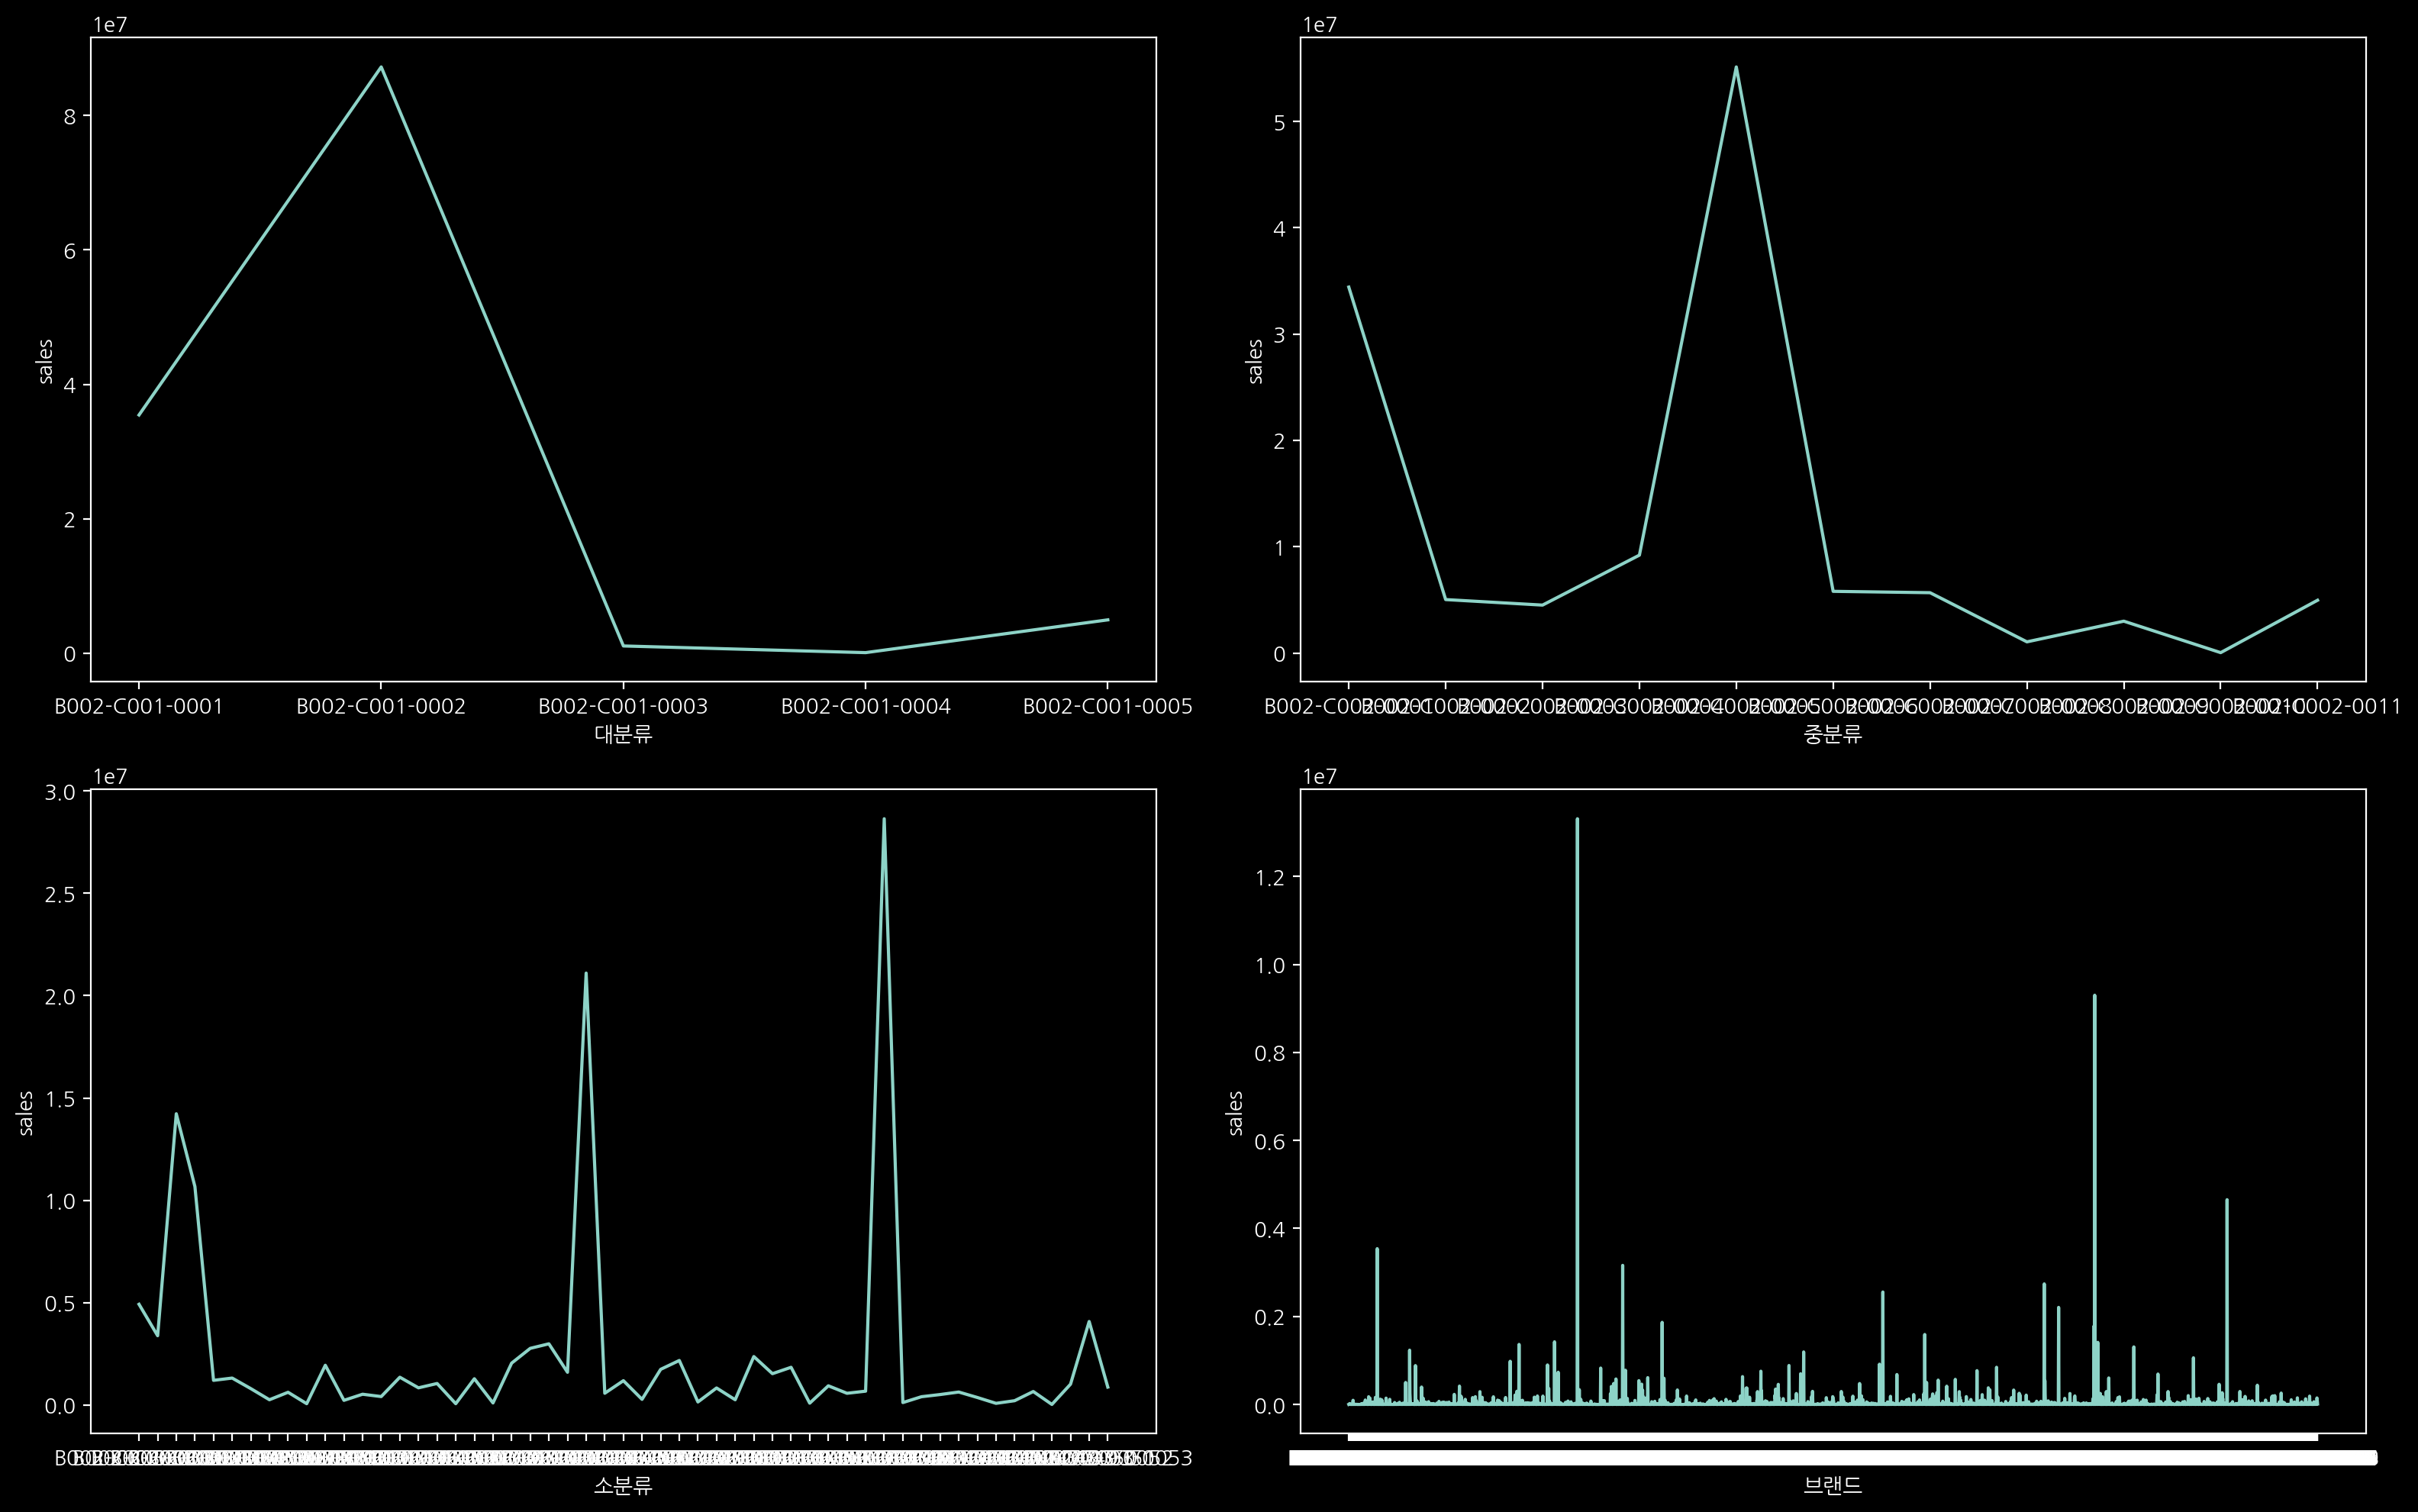

In [8]:
group_col = ['대분류', '중분류', '소분류', '브랜드']

fig, axes = plt.subplots(2, 2, figsize = [16, 10])
axes = axes.flatten()

for idx, col in enumerate(group_col):
    grouped_data = df_train.groupby(col)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

    sns.lineplot(data = grouped_data, x = col, y = 'sales', ax = axes[idx])

plt.tight_layout()
plt.show()

In [9]:
col_name = df_train.iloc[:, 6:].columns.to_list()
df_train.groupby('대분류', as_index = False)['sales'].sum()

,대분류,sales
0,B002-C001-0001,35441662
1,B002-C001-0002,87218401
2,B002-C001-0003,1078827
3,B002-C001-0004,85411
4,B002-C001-0005,4961560


In [10]:
print('train_enc과 df_brand의 브랜드 갯수의 동일 여부 :', df_train.브랜드.nunique() == df_brand.브랜드.nunique())
print('브랜드 개수 :',df_brand.브랜드.nunique())

train_enc과 df_brand의 브랜드 갯수의 동일 여부 : True
브랜드 개수 : 3170


## Brand 인지도 정규화 데이터 EDA

In [11]:
df_keyword = df_brand.iloc[:, 1:]
display(df_keyword.head(3))

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,1.23295,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,16.23150,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
2,0.33362,0.43516,0.36263,0.17406,0.21758,0.46417,0.42065,0.29010,0.37713,0.75427,...,0.53669,0.69625,0.44966,0.39164,1.02988,0.49318,0.91383,0.79779,1.01537,0.88482


In [12]:
na_list = []
for i in range(df_keyword.shape[0]):
    sum_ = sum(df_keyword.iloc[i, :].isna())
    if sum_ is not 0:
        na_list.append(df_brand.iloc[i, :].브랜드)

na_idx = []
for brand in na_list:
   na_idx.append(df_brand[df_brand.브랜드 == brand].index[0])

brand_new = df_brand.drop(na_idx, axis = 0)
brand_new = brand_new.reset_index(drop = True)
brand_new

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.450530,2.422390,1.871190,1.581080,1.232950,1.174930,1.145920,...,0.319110,0.391640,0.377130,0.49318,0.072520,0.29010,0.31911,0.232080,0.333620,0.44966
1,B002-00002,12.64868,20.27850,15.332170,12.750210,13.562510,13.707570,11.937910,15.564250,14.084710,...,10.269790,11.966920,10.646930,10.41485,10.487380,9.48651,9.28343,10.429350,11.154620,11.38671
2,B002-00003,0.33362,0.43516,0.362630,0.174060,0.217580,0.464170,0.420650,0.290100,0.377130,...,0.536690,0.696250,0.449660,0.39164,1.029880,0.49318,0.91383,0.797790,1.015370,0.88482
3,B002-00005,1.07339,1.71163,2.016240,1.914700,1.987230,2.146790,1.682620,1.378000,1.421520,...,2.219320,2.509420,2.872060,2.37888,2.030750,1.53756,1.34899,1.261960,2.320850,2.30635
4,B002-00006,0.00000,0.00000,0.188558,0.246574,0.246574,0.246574,0.377139,0.087012,0.261084,...,0.072526,0.290103,0.087012,0.00000,0.130542,0.00000,0.00000,0.072526,0.217577,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,B002-03794,2.32085,2.98810,3.611830,4.061500,3.669850,3.771390,3.031620,2.988100,3.133150,...,2.422390,2.422390,2.756010,2.32085,2.088770,1.98723,1.07339,1.929210,2.509420,1.78416
3131,B002-03795,0.14505,0.00000,0.087030,0.072520,0.087030,0.101530,0.072520,0.130540,0.116040,...,0.000000,0.072520,0.000000,0.10153,0.101530,0.00000,0.00000,0.000000,0.000000,0.00000
3132,B002-03796,0.00000,0.00000,0.000000,0.000000,0.000000,0.101530,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.072520,0.07252
3133,B002-03798,0.14505,0.00000,0.116040,0.072520,0.116040,0.275600,0.217580,0.116040,0.101530,...,0.101530,0.087030,0.145050,0.17406,0.188560,0.11604,0.11604,0.087030,0.174060,0.10153


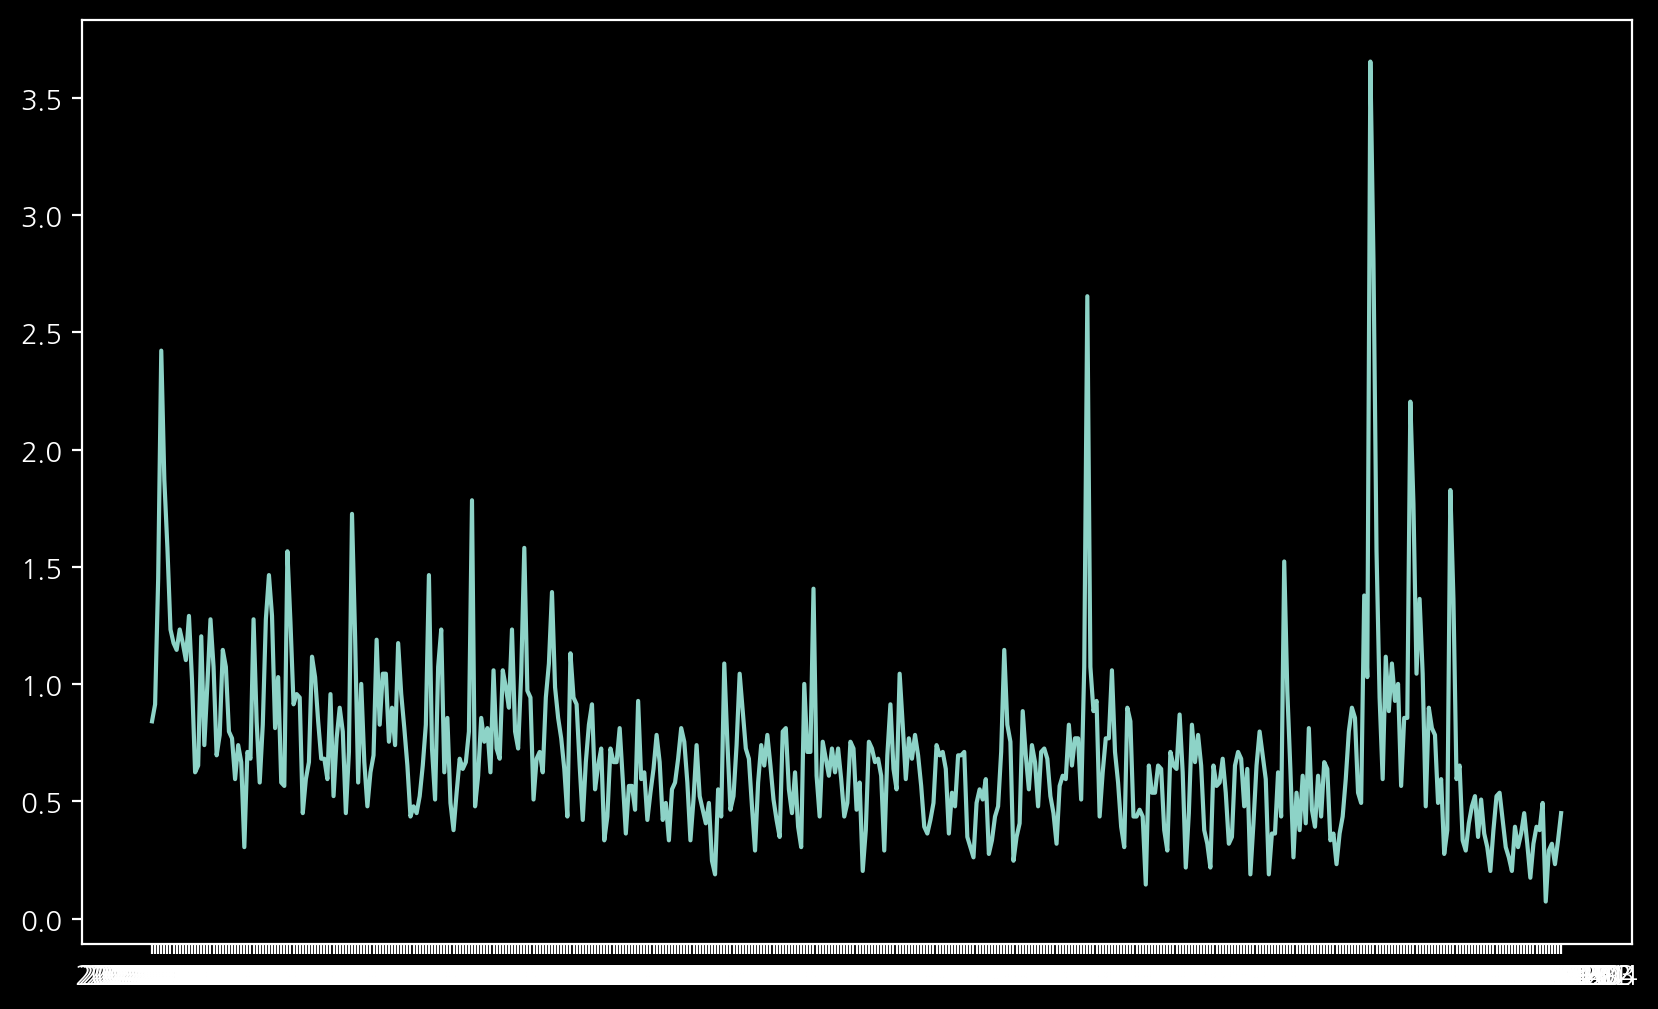

In [13]:
plt.figure(figsize = (10, 6))
test_1 = pd.DataFrame(brand_new.iloc[0, 1:])
plt.plot(test_1)
plt.show()

In [14]:
keyword_num = brand_new.iloc[:, 1:]
arr_keyword = np.array(keyword_num)
brand_mean_li = []  # 각 브랜드 별 평균값을 저장
day_mean_li = []    # 각 일자 별 평균값을 저장
for i in range(arr_keyword.shape[0]):
    brand_mean_li.append(np.mean(arr_keyword[i][:]))

for i in range(arr_keyword.shape[1]):
    day_mean_li.append(np.mean(arr_keyword[:, i]))

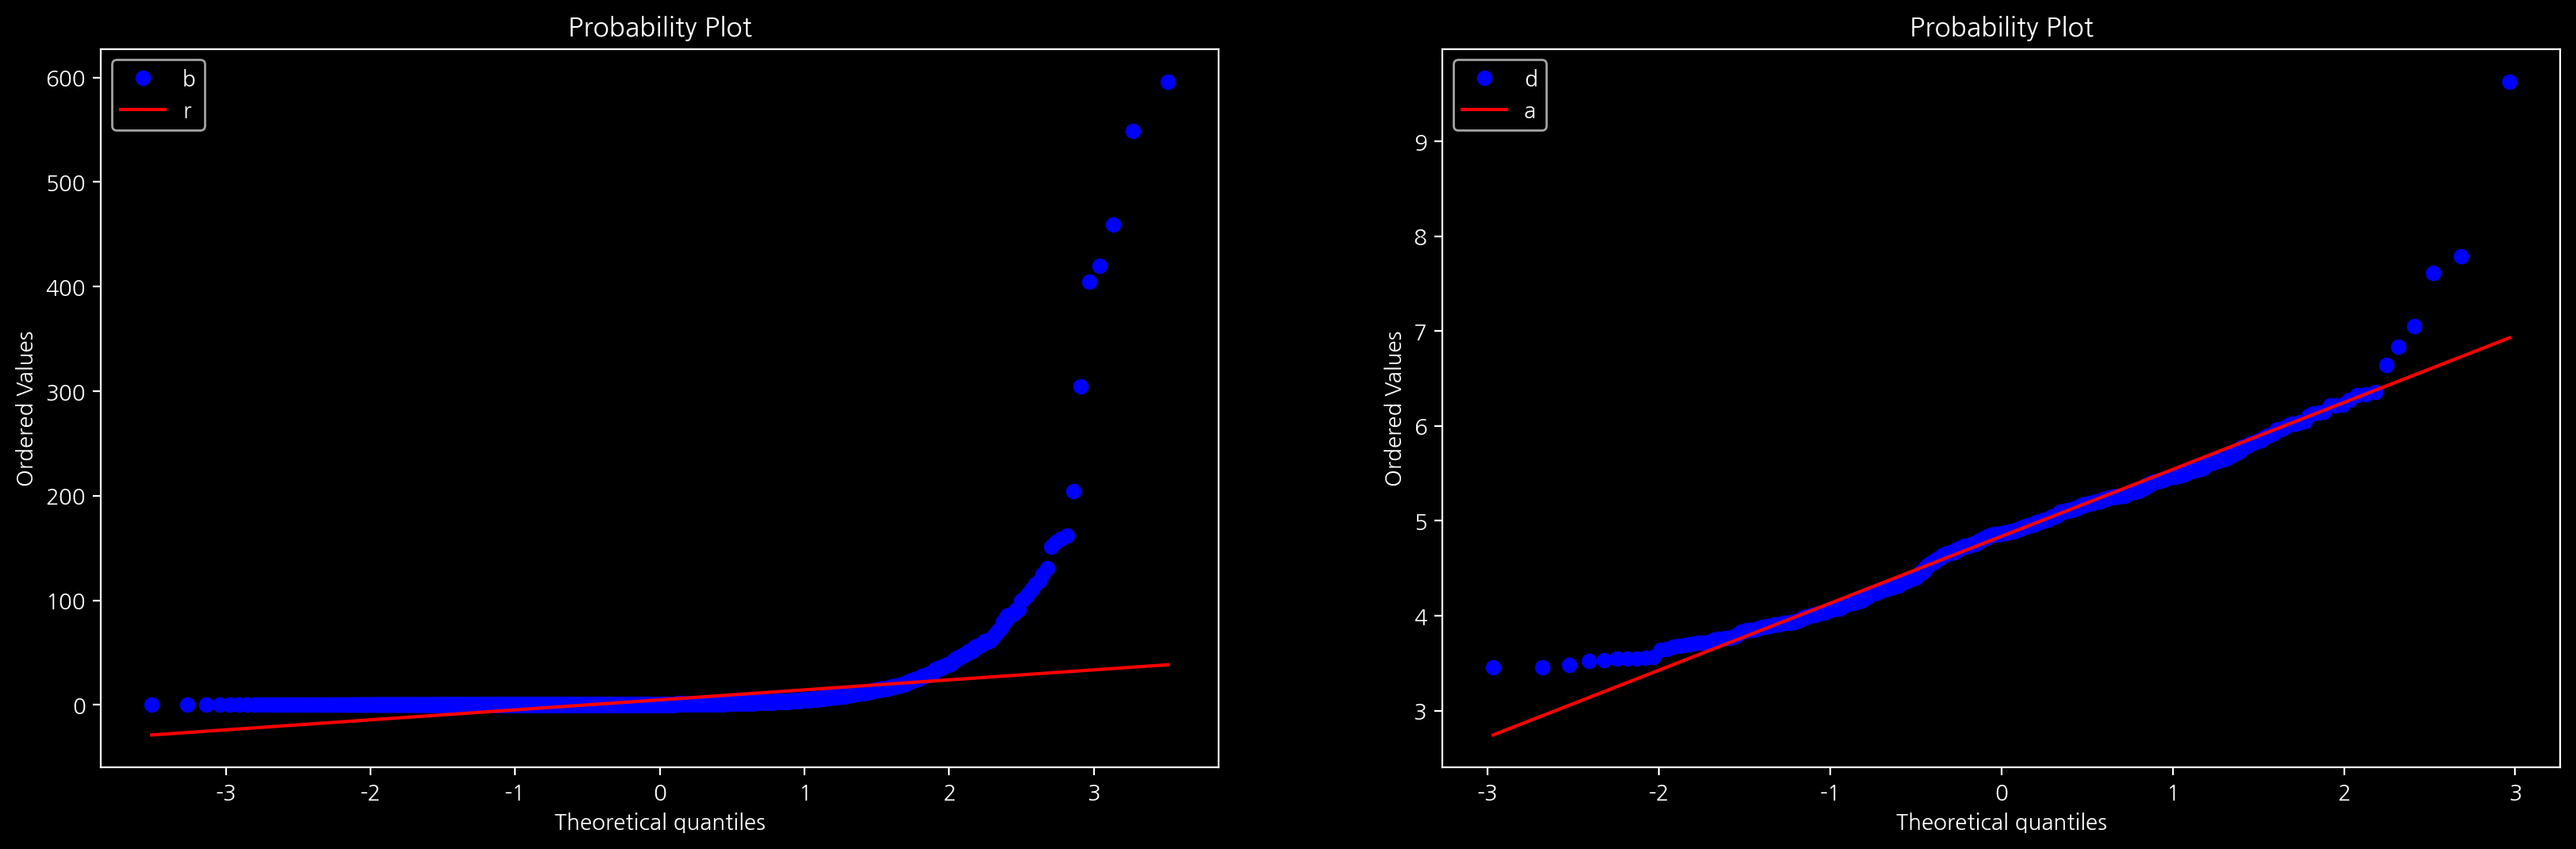

In [15]:
# 각 일자별 브랜드 인지도의 평균은 정규성을 갖음
## NA값을 각 일자별 인지도의 평균으로 채워 넣어도 될 거 같음

fig = plt.figure(figsize = [20, 20])
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)

col = [brand_mean_li, day_mean_li]
ax = [ax1, ax2]
col_name = ['brand_mean', 'day_mean']
zip_ = zip(ax, col, col_name)

for a, c, n in zip_:
    stats.probplot(np.array(c), dist = stats.norm, plot = a)
    a.legend(n)

plt.show()

In [16]:
for i in na_idx:
    df_brand.loc[i, '2022-01-01':] = day_mean_li

brand = df_brand.melt('브랜드').rename(columns = {'variable' : 'date', 'value' : 'keyword'})
brand['date'] = pd.to_datetime(brand['date'])

brand.head(3)

,브랜드,date,keyword
0,B002-00001,2022-01-01,0.84131
1,B002-00002,2022-01-01,12.64868
2,B002-00003,2022-01-01,0.33362


In [18]:
# df_train에 df_brand에서의 keyword 변수 추가

df_train = pd.merge(df_train, brand, on = ['브랜드', 'date'])
df_train.head(3)

,ID,제품,대분류,중분류,소분류,브랜드,date,sales,year,month,day,day_of_week,day_name,quarter,keyword
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,1,5,Saturday,1,0.84131
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1,12.64868
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1,12.64868


In [19]:
brand_list = list(df_brand.브랜드.values)
for i in range(train.shape[0]):
    if train.loc[i, '브랜드'] in brand_list:
        pass
    else:
        train.drop(i, axis = 0, inplace = True)

In [20]:
sales_by_brand = train.iloc[:, 5:]
sales_by_brand = sales_by_brand.groupby('브랜드', as_index = False).sum()

In [21]:
product_brand_cnt = pd.merge(train, df_brand, on = "브랜드")
product_brand_cnt.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01_x,2022-01-02_x,2022-01-03_x,2022-01-04_x,...,2023-03-26_y,2023-03-27_y,2023-03-28_y,2023-03-29_y,2023-03-30_y,2023-03-31_y,2023-04-01_y,2023-04-02_y,2023-04-03_y,2023-04-04_y
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0.53669,0.69625,0.44966,0.39164,1.02988,0.49318,0.91383,0.79779,1.01537,0.88482


In [22]:
col_drop = product_brand_cnt.iloc[:, 6:465].columns.to_list()
product_brand_cnt.drop(col_drop, axis = 1, inplace = True)

In [23]:
# data 날짝 칼럼명 바꾸기
def date_replace(data):
    replace_date = list(pd.Series(data.columns).str.replace('_y', ''))[6:]
    date = list(data.columns)[6:]

    replace_ = {}
    for i in range(len(date)):
        replace_[date[i]] = replace_date[i]

    data = data.rename(columns = replace_)
    return data

product_cnt = date_replace(product_brand_cnt)
product_cnt.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0.84131,0.91383,1.45053,2.42239,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,12.64868,20.27850,15.33217,12.75021,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,12.64868,20.27850,15.33217,12.75021,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,12.64868,20.27850,15.33217,12.75021,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0.33362,0.43516,0.36263,0.17406,...,0.53669,0.69625,0.44966,0.39164,1.02988,0.49318,0.91383,0.79779,1.01537,0.88482


In [24]:
# Label Encoding
encoder_train = LabelEncoder()
encoder = LabelEncoder()
col = ['대분류', '중분류', '소분류', '브랜드']

for c in col:
    product_cnt[c] = encoder.fit_transform(product_cnt[c])
    train[c] = encoder_train.fit_transform(train[c])

In [25]:
display(train.head(3))
display(product_cnt.head(3))

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,1,6,37,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,2,7,43,1,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,2,7,43,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,1,6,37,0,0.84131,0.91383,1.45053,2.42239,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,1,B002-00002-00001,2,7,43,1,12.64868,20.27850,15.33217,12.75021,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671
2,2,B002-00002-00002,2,7,43,1,12.64868,20.27850,15.33217,12.75021,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


## FEATURE ENGINEERING
#### Features

* ID - 제품 ID
* 제품 - 제품 코드
* [O] 대분류 - 제품의 대분류
* [O] 중분류 - 제품의 중분류
* [O] 소분류 - 제품의 소분류
* [O] 브랜드 - 제품의 브랜드
* [X] date - 제품의 판매 날짜
* [X] sales - 제품의 일별 판매량
* [O] quarter - 제품의 판매 분기 (1, 2, 3, 4)분기 존재
* [O] day_name - 제품의 판매 요일
* [O] keyword - 정규화된 제품 브랜드의 키워드 언급 횟수 : 브랜드의 인지도로 판단
* [O] price - 제품의 판매 가격(₩)

#### Event
* LG Event
    * 2022.03.28 ~ 2022.04.03 : LG생활건강 생필품 할인 이벤트 [7days]
    * 2022.07.05 ~ 2022.07.31 : 창립 75주년 고객 이벤트 [27days]
    * 2022.08.11 ~ 2022.09.04 : 네고왕 추석특집 [25days]
    * 2022.10.31 ~ 2022.11.11 : LG생활건강 브랜드 데이 [12days]
    * 2022.11.21 ~ 2022.11.27 : LG 블랙프라이 데이 [7days]

* 연간 이벤트
    * `/home/a1r/바탕화면/DL/DL_aimer/data/korea_anv.csv 참고`

In [26]:
drop_columns = ['제품', '대분류', '중분류', '소분류', '브랜드']
df_price = data_melt(sales).rename(columns = {'sales' : 'price'}).drop(drop_columns, axis = 1)
df_price['date'] = pd.to_datetime(df_price['date'])
df_train = pd.merge(df_train, df_price, on = ['ID', 'date'])
df_train.head(3)

,ID,제품,대분류,중분류,소분류,브랜드,date,sales,year,month,day,day_of_week,day_name,quarter,keyword,price
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,1,5,Saturday,1,0.84131,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1,12.64868,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,2022-01-01,0,2022,1,1,5,Saturday,1,12.64868,0


In [27]:
kor_anv = pd.read_csv(PATH + 'korea_anv.csv')
kor_anv = kor_anv.iloc[:25, :]

def del_str(subject):
    subject = subject.replace(' 다음 날', '')
    subject = subject.replace(' 전날', '')
    subject = subject.replace('대체공휴일', '')
    subject = subject.replace('(', '')
    subject = subject.replace(')', '')

    return subject

kor_anv.Subject = kor_anv.Subject.map(del_str)
kor_anv = kor_anv.rename(columns = {'Start date' : 'date' , 'Subject' : 'event'})
kor_anv['date'] = pd.to_datetime(kor_anv['date'])

event = sales.iloc[0:1, 5:].rename(columns = {'브랜드' : 'zero'})
event.iloc[0, :] = np.zeros(event.shape[1])
event = event.melt('zero').rename(columns = {'variable' : 'date'}).drop('value', axis = 1)
event['date'] = pd.to_datetime(event['date'])

In [28]:
"""    
2022.03.28 ~ 2022.04.03 : LG생활건강 생필품 할인 이벤트 [7days]
2022.07.05 ~ 2022.07.31 : 창립 75주년 고객 이벤트 [27days]
2022.08.11 ~ 2022.09.04 : 네고왕 추석특집 [25days]
2022.10.31 ~ 2022.11.11 : LG생활건강 브랜드 데이 [12days]
2022.11.21 ~ 2022.11.27 : LG 블랙프라이 데이 [7days]
"""
event_dict = {}
event_sub = pd.DataFrame(columns = ['date', 'event'])
start_date = ['2022-03-28', '2022-07-05', '2022-08-11', '2022-10-31', '2022-11-21']
term = [7, 27, 25, 12, 7]
lg_event = ['LG생활건강 생필품 할인 이벤트', '창립 75주년 고객 이벤트', '네고왕 추석특집', 'LG생활건강 브랜드 데이', 'LG 블랙프라이 데이']

for idx, date in enumerate(start_date):
    period = term[idx]  # scalar

    for i in range(period):
        event_dict[list(np.array(pd.date_range(date, periods = period)).astype(str))[i].split('T')[0]] = lg_event[idx] # 날짜

event_sub['date'] = event_dict.keys()
event_sub['event'] = event_dict.values()
event_sub['date'] = pd.to_datetime(event_sub['date'])

df_event = pd.merge(event, pd.concat([kor_anv, event_sub]), how = 'outer', on = 'date').drop('zero', axis = 1)
df_event.event = df_event.event.fillna(0)

In [29]:
df_train = pd.merge(df_train, df_event, on = 'date')

In [30]:
df_train.to_csv(PATH + 'train_fe.csv', index_label=False)

In [ ]:
# df_train.melt(id_vars=df_train.iloc[:, 6], value_vars=df_train.iloc[:, :6].columns.to_list())
# df_train.iloc[:, :6].columns.to_list()
sale_by_large = datetime(df_train.groupby(['대분류', 'date'], as_index = False)['sales'].sum())
sale_by_medium = datetime(df_train.groupby(['중분류', 'date'], as_index = False)['sales'].sum())
sale_by_small = datetime(df_train.groupby(['소분류', 'date'], as_index = False)['sales'].sum())
sale_by_brand = datetime(df_train.groupby(['브랜드', 'date'], as_index = False)['sales'].sum())

sale_by_large = sale_by_large.set_index('date')

le = LabelEncoder()

le.fit(sale_by_large['day_name'])
sale_by_large['day_name'] = le.transform(sale_by_large['day_name'])

In [ ]:
sale_by_large

## Data Preprocessing

### Make Dataset

In [ ]:
class IndividualMinMaxScaler:
    def __get_min_val(self, df, date_cols):
        df_mins = df[date_cols].min(axis=1).to_numpy()
        return df_mins

    def __get_max_val(self, df, date_cols):
        df_maxs = df[date_cols].max(axis=1).to_numpy()
        return df_maxs


    def fit(self, df: pd.DataFrame):
        date_cols = [col for col in df.columns
                     if col.startswith("2")]

        self.min_val = self.__get_min_val(df, date_cols)
        self.max_val = self.__get_max_val(df, date_cols)
        denom = self.max_val - self.min_val
        self.denom = np.where(denom==0, 1, denom)

    def transform(self, df: pd.DataFrame):
        date_cols = [col for col in df.columns
                     if col.startswith("2")]
        return df[date_cols] \
            .apply(lambda x: (x-self.min_val)/self.denom)

    def fit_transform(self, df: pd.DataFrame):
        self.fit(df)
        return self.transform(df)

In [ ]:
date_cols = [col for col in train.columns if col.startswith("2")]
df_mins = train[date_cols].min(axis=1).to_numpy()
df_maxs = train[date_cols].max(axis=1).to_numpy()
print(df_mins)
print(df_maxs)

denom = df_maxs - df_mins
denom = np.where(denom==0, 1, denom)
print(denom)

In [ ]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':5e-6,
    'BATCH_SIZE':2048,
    'SEED':41
}

PATH = os.getcwd() + '/data/'

In [ ]:
train.head(3)

In [ ]:
# Data Scaling

# scale_max_dict = {}
# scale_min_dict = {}

# for idx in tqdm(range(len(train))):
#     maxi = np.max(train.iloc[idx,4:])
#     mini = np.min(train.iloc[idx,4:])
    
#     if maxi == mini :
#         train.iloc[idx,4:] = 0
#     else:
#         train.iloc[idx,4:] = (train.iloc[idx,4:] - mini) / (maxi - mini)
    
#     scale_max_dict[idx] = maxi
#     scale_min_dict[idx] = mini

train_scale = train.copy()
product_scale = product_cnt.copy()

train_scale.drop(['ID', '제품'], axis = 1, inplace = True)
scaler = IndividualMinMaxScaler()
train_scale.iloc[:, 4:] = scaler.fit_transform(train)
print(min(train_scale.iloc[:, 6]), max(train_scale.iloc[:, 6]))

product_scale.drop(['ID', '제품'], axis = 1, inplace = True)
scaler = IndividualMinMaxScaler()
product_scale.iloc[:, 4:] = scaler.fit_transform(product_cnt)
print(min(product_scale.iloc[:, 6]), max(product_scale.iloc[:, 6]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [20, 6])
ax = ax.flatten()

sns.lineplot(train_scale.iloc[2,6:97], ax = ax[0])
sns.lineplot(product_scale.iloc[2,6:97], ax = ax[1])
plt.show()

In [ ]:
SEED = 41

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

seed_everything(SEED) # Seed 고정

In [ ]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간 => 90 Days
    predict_size : 추론할 기간 => 21 Days
    '''
    num_rows = len(data) # 15890
    window_size = train_size + predict_size # 90 + 21 = 111
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1), dtype = np.float16)
    # (5609170, 90, 5)
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size), dtype = np.float16)
    # (5640950, 21)

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])  # Label: 대분류, 중분류, 소분류, 브랜드
        sales_data = np.array(data.iloc[i, 4:]) # 날짜 데이터: 2022-01-01 ~ 2023-04-04
        
        for j in range(len(sales_data) - window_size + 1): # 0 ~ 348
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [ ]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1), dtype = np.float16)
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

##### Scaling한 데이터 2개를 병합

In [ ]:
train_scale_arr = np.array(train_scale.iloc[:, 4:]).astype(np.float32)
product_scale_arr = np.array(product_scale.iloc[:, 4:]).astype(np.float32)
train_scale_tensor = torch.from_numpy(train_scale_arr).unsqueeze(0)
product_scale_tensor = torch.from_numpy(product_scale_arr).unsqueeze(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gate_layer = nn.Linear(918, 459, device = device)
gate_sigmoid = nn.Sigmoid().to(device)


def gate(tensor_1, tensor_2, device = device):  # tensor_1, tensor_2는 3차원
    tensor_1 = tensor_1.to(device)
    tensor_2 = tensor_2.to(device)
    tensor_concat = torch.cat((tensor_1, tensor_2), -1)
    tensor_concat = tensor_concat.to(device)
    tensor_gate = gate_sigmoid(gate_layer(tensor_concat))

    train_product_gate = torch.add(tensor_gate * tensor_1, (1.- tensor_gate) * tensor_2).squeeze()
    gate_arr = train_product_gate.cpu().detach().numpy()

    return gate_arr

gate_arr = gate(train_scale_tensor, product_scale_tensor)
train_gate = train.copy()
train_gate.iloc[:, 6:] = gate_arr
train_gate.to_csv(PATH + 'train_gate_after_scaling.csv', index_label = False)

##### Scaling하지 않고 데이터 2개를 병합

In [ ]:
train_arr = np.array(train.iloc[:, 6:]).astype(np.float32)
product_arr = np.array(product_cnt.iloc[:, 6:]).astype(np.float32)
train_tensor = torch.from_numpy(train_scale_arr).unsqueeze(0)
product_tensor = torch.from_numpy(product_scale_arr).unsqueeze(0)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gate_layer = nn.Linear(918, 459, device = device)
gate_sigmoid = nn.Sigmoid().to(device)


def gate(tensor_1, tensor_2, device = device):  # tensor_1, tensor_2는 3차원
    tensor_1 = tensor_1.to(device)
    tensor_2 = tensor_2.to(device)
    tensor_concat = torch.cat((tensor_1, tensor_2), -1)
    tensor_concat = tensor_concat.to(device)
    tensor_gate = gate_sigmoid(gate_layer(tensor_concat))

    train_product_gate = torch.add(tensor_gate * tensor_1, (1.- tensor_gate) * tensor_2).squeeze()
    gate_arr = train_product_gate.cpu().detach().numpy()

    return gate_arr

gate_arr = gate(train_tensor, product_tensor)
train_gate = train.copy()
train_gate.iloc[:, 6:] = gate_arr
train_gate.to_csv(PATH + 'train_gate_before_scaling.csv', index_label=False)

In [ ]:
train_input, train_target = make_train_data(train_scale)
test_input = make_predict_data(train_scale)

In [ ]:
product_input, product_target = make_train_data(product_scale)
product_test_input = make_predict_data(product_scale)

In [ ]:
def train_val_split(input_data, target_data):
    data_len = len(input_data)
    val_input = input_data[-int(data_len*0.2):]
    val_target = target_data[-int(data_len*0.2):]
    train_input = input_data[:-int(data_len*0.2)]
    train_target = target_data[:-int(data_len*0.2)]

    return train_input, train_target, val_input, val_target